In [1]:
import numpy as np  
import matplotlib.pyplot as plt 
import os                  
from PIL import Image
import pandas as pd 

import tensorflow as tf
import keras 
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model

#from inference import Inference
from aipilot.tf.cv import DataPrep , GradCam
from aipilot.tf import Devices, callbacks, Evaluator
import cv2

In [2]:
# Check if TensorFlow can detect a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
devices = Devices()
devices.gpu_device

[INFO] Tensorflow is built with cuda support ✅
[INFO] [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[INFO] {'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU', 'compute_capability': (8, 6)}


In [4]:
# Set the base directory to the dataset's root
BASE_DIR = "C:\\brain-tumor-classification-notebooks"

# Define the dataset directory
DATA_DIR = os.path.join(BASE_DIR, "cropped", "Training")

# Define the artifacts directory
ARTIFACTS_DIR = os.path.join(BASE_DIR, "artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Define the checkpoint directory
CKPT_DIR = os.path.join(ARTIFACTS_DIR, "ckpt")
os.makedirs(CKPT_DIR, exist_ok=True)

# Define the models directory
MODELS_DIR = os.path.join(ARTIFACTS_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

# Define the logs directory
LOGS_DIR = os.path.join(BASE_DIR, "logs")
os.makedirs(LOGS_DIR, exist_ok=True)

# Define file names for the checkpoint and model
CKPT_FILE_NAME = os.path.join(CKPT_DIR, ".mdl_wts.hdf5")
MODEL_NAME = os.path.join(MODELS_DIR, "model.h5")

# Print paths to verify
print("Dataset Directory:", DATA_DIR)
print("Artifacts Directory:", ARTIFACTS_DIR)
print("Checkpoint File Path:", CKPT_FILE_NAME)
print("Model File Path:", MODEL_NAME)
print("Logs Directory:", LOGS_DIR)


Dataset Directory: C:\brain-tumor-classification-notebooks\cropped\Training
Artifacts Directory: C:\brain-tumor-classification-notebooks\artifacts
Checkpoint File Path: C:\brain-tumor-classification-notebooks\artifacts\ckpt\.mdl_wts.hdf5
Model File Path: C:\brain-tumor-classification-notebooks\artifacts\models\model.h5
Logs Directory: C:\brain-tumor-classification-notebooks\logs


Found 5712 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


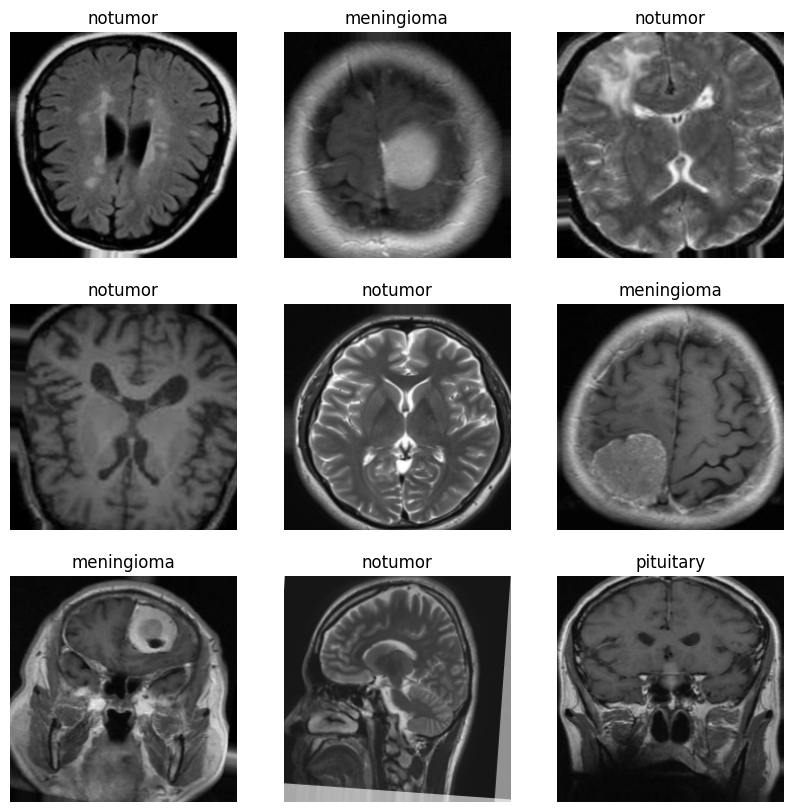

In [5]:
data_ops = DataPrep(DATA_DIR)
custom_data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,                        
        width_shift_range=0.05,
        rescale=1./255,
        height_shift_range=0.05,
        horizontal_flip=True)
train_generator, valid_generator = data_ops.data_generators( val_split=0.2, batch_size=16,
                                                            data_augmentation= True,
                                                            augmentation_strategy= custom_data_augmentation)
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
img = data_ops.sample_images(train_generator)

In [6]:
data_ops.classwise_img_count(train_generator)

{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}

In [7]:
data_ops.classwise_img_count(valid_generator)

{'glioma': 264, 'meningioma': 267, 'notumor': 319, 'pituitary': 291}

In [8]:
(early_stopping_cb, checkpointing_cb,
 tensorboard_cb, reduce_on_plateau_cb) = callbacks(
                                                   CKPT_FILE_NAME,LOGS_DIR, es_patience=50, lr_patience=3
                                                    )

In [52]:
conv_base = EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape = (300, 300, 3)
)
for layer in conv_base.layers[:-5]:
    layer.trainable = False

In [53]:
x = conv_base.output    
x = GlobalAveragePooling2D()(x)
x = Dense(units=512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(units=64)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(units=32, activation='relu')(x)
predictions = layers.Dense(4, activation='softmax')(x)
model = Model(conv_base.input, outputs = predictions)

In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [55]:
history = []

In [56]:
h = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    callbacks = [tensorboard_cb , early_stopping_cb, checkpointing_cb, reduce_on_plateau_cb]
    )
history.append(h)

Epoch 1/50
357/357 [==============================] - 57s 144ms/step - loss: 0.5003 - accuracy: 0.8130 - val_loss: 0.3367 - val_accuracy: 0.8688 - lr: 0.0010
Epoch 2/50
357/357 [==============================] - 52s 146ms/step - loss: 0.3209 - accuracy: 0.8813 - val_loss: 0.2007 - val_accuracy: 0.9269 - lr: 0.0010
Epoch 3/50
357/357 [==============================] - 55s 154ms/step - loss: 0.2875 - accuracy: 0.8902 - val_loss: 0.1709 - val_accuracy: 0.9349 - lr: 0.0010
Epoch 4/50
357/357 [==============================] - 55s 154ms/step - loss: 0.2462 - accuracy: 0.9077 - val_loss: 0.1522 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 5/50
357/357 [==============================] - 54s 150ms/step - loss: 0.2441 - accuracy: 0.9128 - val_loss: 0.1626 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 6/50
357/357 [==============================] - 55s 153ms/step - loss: 0.1977 - accuracy: 0.9279 - val_loss: 0.1257 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 7/50
357/357 [==============================] 

Epoch 49/50
357/357 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9891
Epoch 49: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
357/357 [==============================] - 58s 161ms/step - loss: 0.0356 - accuracy: 0.9891 - val_loss: 0.0043 - val_accuracy: 0.9991 - lr: 8.0000e-06
Epoch 50/50
357/357 [==============================] - 58s 163ms/step - loss: 0.0367 - accuracy: 0.9872 - val_loss: 0.0045 - val_accuracy: 0.9991 - lr: 1.6000e-06


In [65]:
saved_ckpt = os.path.join( CKPT_FILE_NAME)
loaded_ckpt = keras.models.load_model(saved_ckpt)

In [ ]:
#starting the training again from the last checkpoint
h = loaded_ckpt.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    callbacks = [tensorboard_cb , early_stopping_cb, checkpointing_cb, reduce_on_plateau_cb]
    )
history.append(h)

In [66]:
history_df = pd.DataFrame()
for h in history:
    history_df = pd.concat([history_df, pd.DataFrame.from_records(h.history)])

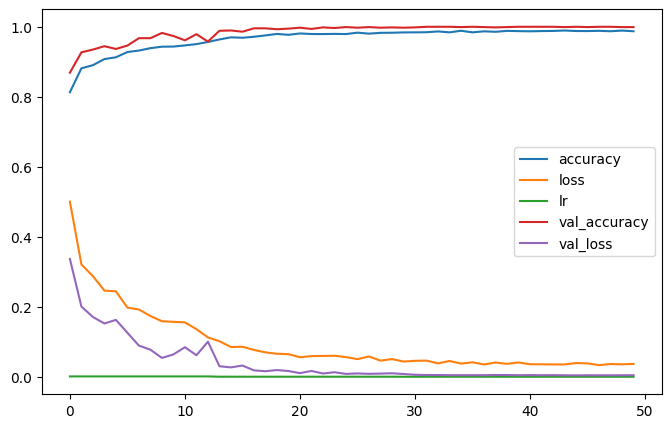

In [67]:
history_df.reset_index(drop=True).plot(figsize= (8,5));

In [68]:
model = load_model(CKPT_FILE_NAME)
model.save(MODEL_NAME)

In [69]:
model = load_model(MODEL_NAME)

In [70]:
%load_ext tensorboard
%tensorboard --logdir logs 

In [71]:
#Get the last conv layer name
for layer in model.layers[-20:]:
    print(layer.name)

conv5_block16_1_bn
conv5_block16_1_relu
conv5_block16_2_conv
conv5_block16_concat
bn
relu
global_average_pooling2d_3
dense_7
batch_normalization_3
activation_3
dropout_4
dense_8
batch_normalization_4
activation_4
dropout_5
dense_9
batch_normalization_5
activation_5
dense_10
dense_11


In [115]:
os.makedirs("inference_images", exist_ok= True)
input_img_path = os.path.join("inference_images", "input.jpg")
preprocessed_img_path = os.path.join("inference_images", "preprocessed.png")
output_img_path = os.path.join("inference_images", "output_img.png")

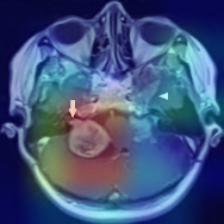

In [119]:
from preprocess import prep_img
img = cv2.imread("./dataset/Testing/meningioma/Te-meTr_0002.jpg")
preprocessed_img = prep_img(img, IMG_SIZE=224)
cv2.imwrite(preprocessed_img_path, preprocessed_img)
gradcam = GradCam(model, "conv5_block16_concat",
                  in_img_path = preprocessed_img_path,
                  out_img_path = output_img_path,
                  normalize_img=True)
gradcam_img = gradcam.get_gradcam()

In [120]:
train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [121]:
# Prediction through GradCam
gradcam.preds.numpy()

array([[1.7845858e-05, 9.9665016e-01, 3.3289855e-03, 3.0692538e-06]],
      dtype=float32)

In [99]:
# checking the accuracy 
result = model.evaluate(valid_generator)
print('\n', 'Validation Loss:', round(result[0], 3))
print('\n', 'Validation Accuracy:', round(result[1], 3))

72/72 [==============================] - 7s 69ms/step - loss: 0.0040 - accuracy: 1.0000

 Validation Loss: 0.004

 Validation Accuracy: 1.0


In [101]:
eval= Evaluator(model, train_generator, valid_generator)

72/72 [==============================] - 6s 68ms/step


<module 'matplotlib.pyplot' from 'C:\\Users\\hasna\\miniconda3\\envs\\brain-tumour\\lib\\site-packages\\matplotlib\\pyplot.py'>

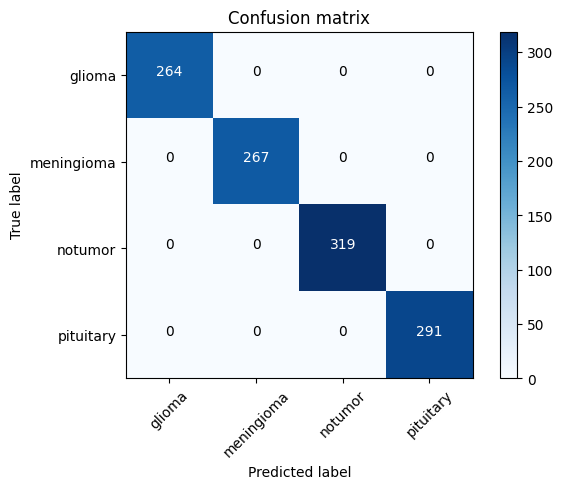

In [102]:
eval.confusion_matrix()

In [103]:
eval.classification_report()

              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       264
  meningioma       1.00      1.00      1.00       267
     notumor       1.00      1.00      1.00       319
   pituitary       1.00      1.00      1.00       291

    accuracy                           1.00      1141
   macro avg       1.00      1.00      1.00      1141
weighted avg       1.00      1.00      1.00      1141



In [104]:
print(train_generator.class_indices)
images, labels = valid_generator.next()
predictions = model.predict(np.expand_dims(images[0], axis=0))
np.argmax(predictions[0])

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
1/1 [==============================] - 1s 1s/step


0

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
1/1 [==============================] - 0s 31ms/step


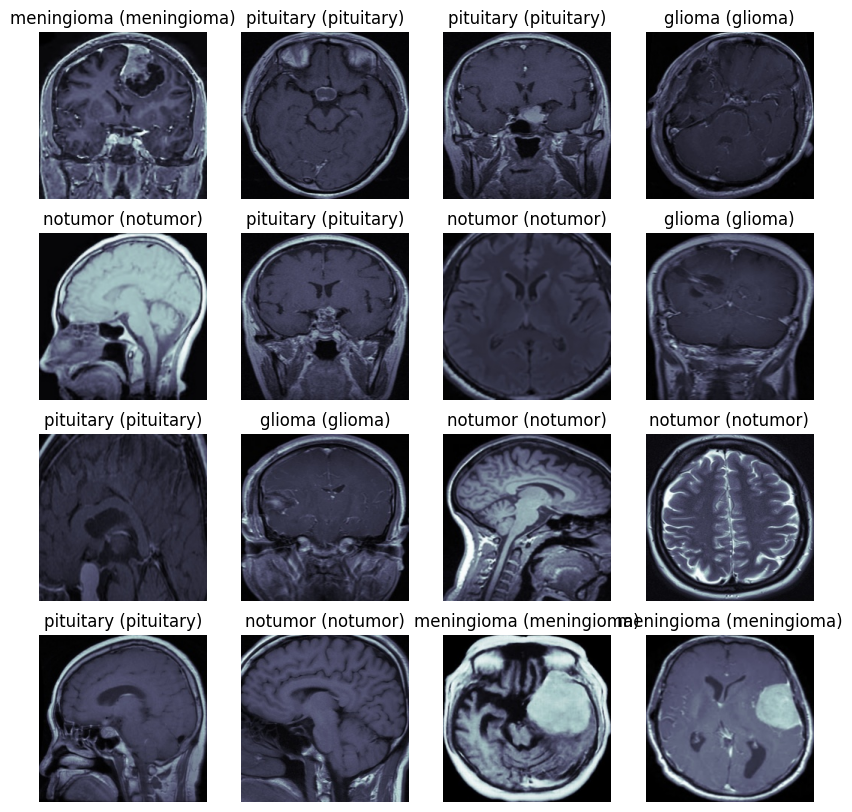

In [105]:
_, valid_generator_with_shuffle  = data_ops.data_generators( val_split=0.2,val_shuffle=True, batch_size=16, data_augmentation= False)
#_, valid_generator_with_shuffle = data_ops.data_generators(train_dir=DATA_DIR, val_shuffle=True, val_dir=TEST_DIR, batch_size=16)
#plot a random sample of test images, their predicted labels, and ground truth
classes = list(train_generator.class_indices.keys())
plt.figure(figsize=(10, 10))
images, labels = valid_generator_with_shuffle.next()
labels = np.argmax(labels, axis=1)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    prediction = classes[np.argmax(model.predict(np.expand_dims(images[i], axis=0))[0], axis=0)]
    plt.imshow(images[i])
    plt.title(f"{classes[labels[i]]} ({prediction})")
    plt.axis("off")

In [122]:
## Making prediction
#img_arr = np.asarray(Image.open("./dataset/normal/NORMAL2-IM-0489-0001.jpeg"))
img = cv2.imread("./dataset/Testing/meningioma/Te-me_0056.jpg")
img_arr = prep_img(img, IMG_SIZE=224)
img_arr =  np.expand_dims(img_arr, axis=0)/255.0
prediction = np.round(model.predict(img_arr), decimals = 6)
prediction

1/1 [==============================] - 0s 39ms/step


array([[9.14000e-04, 9.89926e-01, 9.16000e-03, 1.00000e-06]],
      dtype=float32)

In [123]:
prediction = model.predict(img_arr)
pred_cls_label = np.argmax(prediction, axis=1)[0]
pred_cls_label

1/1 [==============================] - 0s 39ms/step


1

In [124]:
train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [125]:
np.set_printoptions(suppress=True)
print(f"Probability of being Glioma is {round(prediction[0][0]*100, 5)} %")
print(f"Probability of being Meningioma is {round(prediction[0][1]*100, 5)} %")
print(f"Probability of being No tumor is {round(prediction[0][2]*100, 5)} %")
print(f"Probability of being Pituitary is {round(prediction[0][3]*100, 5)} %")

Probability of being Glioma is 0.09138 %
Probability of being Meningioma is 98.99256 %
Probability of being No tumor is 0.91599 %
Probability of being Pituitary is 6e-05 %


In [126]:
pred_cls = eval.class_names[pred_cls_label]
pred_cls

'meningioma'

## Testing on Test Data

### Getting Data Loader

Found 400 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


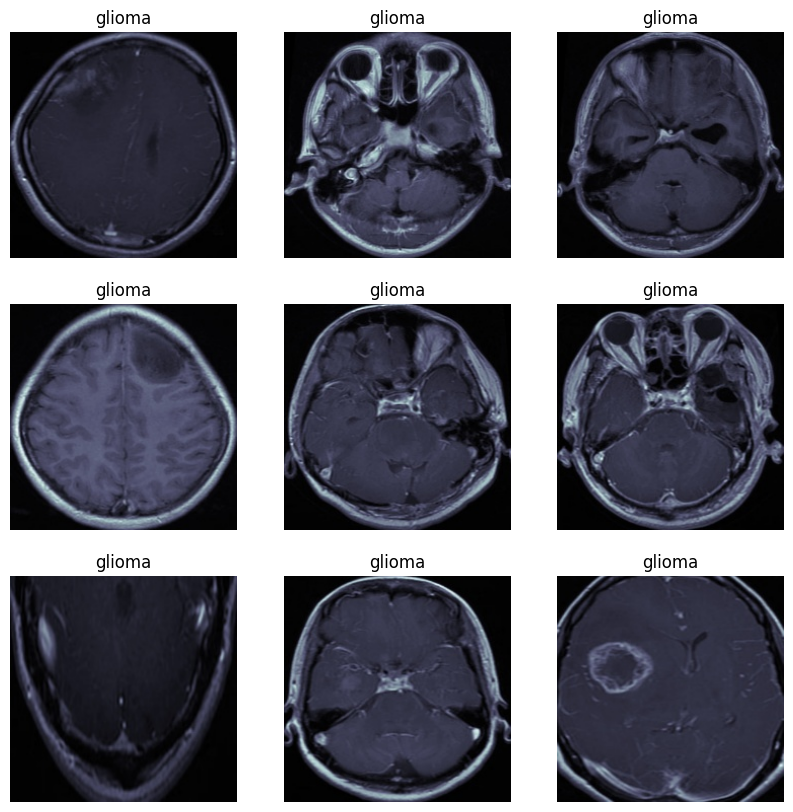

In [13]:
BASE_DIR = os.path.relpath(os.getcwd())
DATA_DIR = os.path.join(BASE_DIR, "dataset", "preprocessed", "Testing")

data_ops = DataPrep(DATA_DIR)
test_generator, _ = data_ops.data_generators( val_split=0.0, batch_size=32, train_shuffle= False,
                                              val_shuffle= False, data_augmentation= False)
img = data_ops.sample_images(test_generator)

In [14]:
# checking the accuracy 
result = model.evaluate(test_generator)
print('\n', 'Test Loss:', round(result[0], 3))
print('\n', 'Test Accuracy:', round(result[1], 3))

13/13 [==============================] - 2s 118ms/step - loss: 0.0168 - accuracy: 0.9950

 Test Loss: 0.017

 Test Accuracy: 0.995


In [18]:
eval= Evaluator(model, train_generator, test_generator)

13/13 [==============================] - 2s 137ms/step


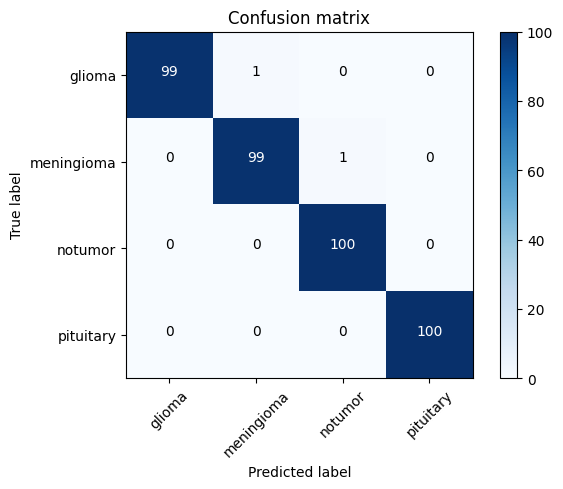

In [22]:
eval.confusion_matrix();

In [21]:
eval.classification_report()

              precision    recall  f1-score   support

      glioma       0.99      1.00      0.99        99
  meningioma       0.99      0.99      0.99       100
     notumor       1.00      0.99      1.00       101
   pituitary       1.00      1.00      1.00       100

    accuracy                           0.99       400
   macro avg       0.99      1.00      0.99       400
weighted avg       1.00      0.99      1.00       400

